# Loading Image Data

So far we've been working with fairly artificial datasets that you wouldn't typically be using in real projects. Instead, you'll likely be dealing with full-sized images like you'd get from smart phone cameras. In this notebook, we'll look at how to load images and use them to train neural networks.

We'll be using a [dataset of cat and dog photos](https://www.kaggle.com/c/dogs-vs-cats) available from Kaggle. Here are a couple example images:

<img src='assets/dog_cat.png'>

We'll use this dataset to train a neural network that can differentiate between cats and dogs. These days it doesn't seem like a big accomplishment, but five years ago it was a serious challenge for computer vision systems.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import helper
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
import torch
from torchvision import datasets, transforms

'''
# Load your dataset (e.g., CIFAR10)
data_dir = '~/.pytorch/Cat_Dog_data/train'
train_transforms = transforms.Compose([transforms.Resize(255),
                                     transforms.RandomResizedCrop(224),
                                     transforms.ToTensor()]) 
dataset = datasets.ImageFolder(data_dir, transform=train_transforms)

# Calculate the mean and standard deviation
mean = 0.0
std = 0.0
num_samples = len(dataset)

for images, labels in dataset:
    # Calculate mean and std for each image
    mean += images.mean(dim=(1, 2))
    std += images.std(dim=(1, 2))

# Average across all images
mean /= num_samples
std /= num_samples
print('mean = ', mean)
print('std deviation = ', std)


# Create a Normalize transform
normalize = transforms.Normalize(mean=mean, std=std)
'''

"\n# Load your dataset (e.g., CIFAR10)\ndata_dir = '~/.pytorch/Cat_Dog_data/train'\ntrain_transforms = transforms.Compose([transforms.Resize(255),\n                                     transforms.RandomResizedCrop(224),\n                                     transforms.ToTensor()]) \ndataset = datasets.ImageFolder(data_dir, transform=train_transforms)\n\n# Calculate the mean and standard deviation\nmean = 0.0\nstd = 0.0\nnum_samples = len(dataset)\n\nfor images, labels in dataset:\n    # Calculate mean and std for each image\n    mean += images.mean(dim=(1, 2))\n    std += images.std(dim=(1, 2))\n\n# Average across all images\nmean /= num_samples\nstd /= num_samples\nprint('mean = ', mean)\nprint('std deviation = ', std)\n\n\n# Create a Normalize transform\nnormalize = transforms.Normalize(mean=mean, std=std)\n"

If you loaded the data correctly, you should see something like this (your image will be different):

<img src='assets/cat_cropped.png' width=244>

In [3]:
import os

data_dir = os.path.expanduser('~/.pytorch/Cat_Dog_data/')

imagenet_mean = (0.485, 0.456, 0.406)
imagenet_std  = (0.229, 0.224, 0.225)

# Transforms (Inception v3 expects 299x299)
train_transforms = transforms.Compose([
    transforms.Resize(299),
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(299),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])

test_transforms = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])

train_data = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_transforms)
test_data  = datasets.ImageFolder(os.path.join(data_dir, 'test'),  transform=test_transforms)

# Windows notebooks often need num_workers=0
num_workers = 0 if os.name == 'nt' else min(4, (os.cpu_count() or 4))

use_cuda = torch.cuda.is_available()
trainloader = torch.utils.data.DataLoader(
    train_data, batch_size=32, shuffle=True,
    num_workers=num_workers, pin_memory=use_cuda
)
testloader = torch.utils.data.DataLoader(
    test_data, batch_size=32, shuffle=False,
    num_workers=num_workers, pin_memory=use_cuda
)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


torch.Size([3, 299, 299])


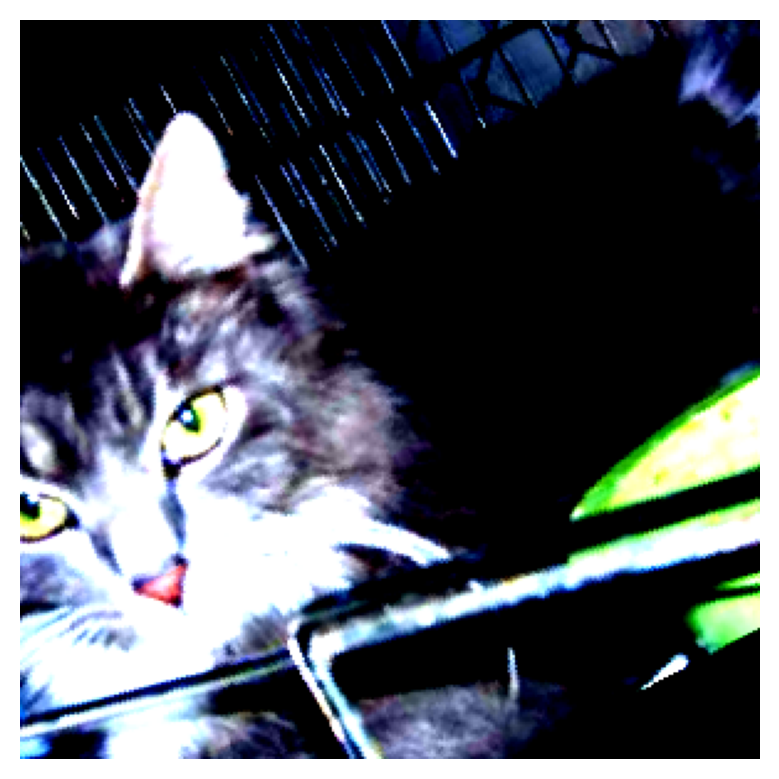

In [4]:
# Run this to test your data loader
images, labels = next(iter(trainloader))
helper.imshow(images[0], normalize=False)
print(images[0].shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


torch.Size([32, 3, 299, 299])


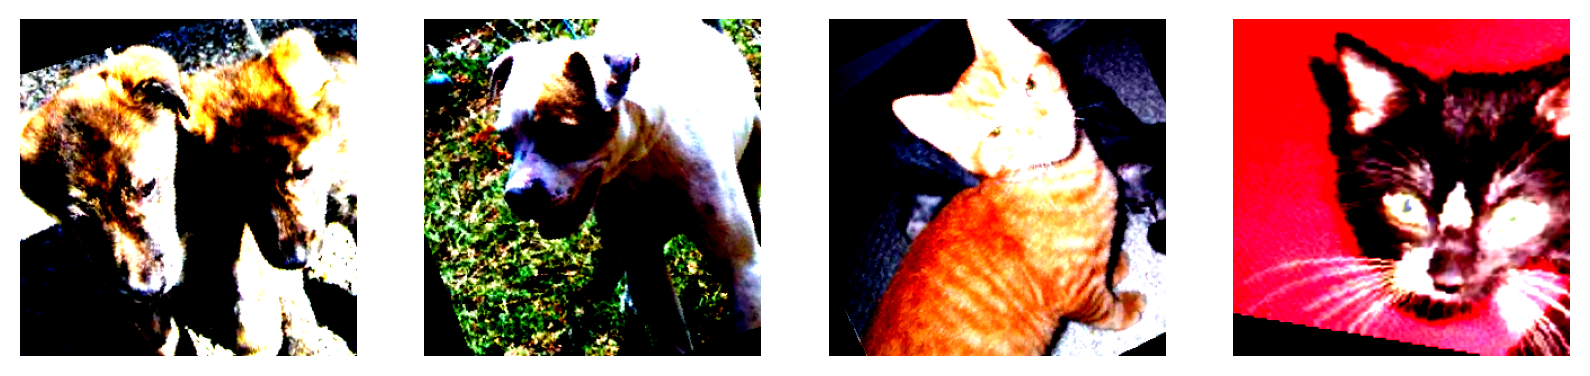

In [5]:
# change this to the trainloader or testloader 
data_iter = iter(trainloader)

images, labels = next(data_iter)
print (images.shape)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    helper.imshow(images[ii], ax=ax, normalize=False)

Your transformed images should look something like this.

<center>Training examples:</center>
<img src='assets/train_examples.png' width=500px>

<center>Testing examples:</center>
<img src='assets/test_examples.png' width=500px>

At this point you should be able to load data for training and testing. Now, you should try building a network that can classify cats vs dogs. This is quite a bit more complicated than before with the MNIST and Fashion-MNIST datasets. To be honest, you probably won't get it to work with a fully-connected network, no matter how deep. These images have three color channels and at a higher resolution (so far you've seen 28x28 images which are tiny).

In the next part, I'll show you how to use a pre-trained network to build a model that can actually solve this problem.

In [6]:
# Optional TODO: Attempt to build a network to classify cats vs dogs from this dataset
# Model: Inception v3 (pretrained) + new classification head
import time
import torch
from torch import nn, optim
import torchvision.models as models
from torch.optim.lr_scheduler import CosineAnnealingLR

print('CUDA available:', torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)

# Load pretrained inception_v3
# NOTE: In torchvision >=0.13, 'pretrained=True' is deprecated in favor of weights=...
# This keeps your original intent but is more future-proof.
try:
    weights = models.Inception_V3_Weights.DEFAULT
    model = models.inception_v3(weights=weights, aux_logits=True)
except Exception:
    model = models.inception_v3(pretrained=True, aux_logits=True)

# Replace final classifiers (2 classes: cat vs dog)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

if model.AuxLogits is not None:
    aux_ftrs = model.AuxLogits.fc.in_features
    model.AuxLogits.fc = nn.Linear(aux_ftrs, 2)

# Freeze the backbone, train only the new heads
for p in model.parameters():
    p.requires_grad = False

for p in model.fc.parameters():
    p.requires_grad = True

if model.AuxLogits is not None:
    for p in model.AuxLogits.parameters():
        p.requires_grad = True

model = model.to(device)

criterion = nn.CrossEntropyLoss()

params_to_train = list(model.fc.parameters())
if model.AuxLogits is not None:
    params_to_train += list(model.AuxLogits.parameters())

optimizer = optim.Adam(params_to_train, lr=1e-3)
scheduler = CosineAnnealingLR(optimizer, T_max=10)

num_epochs = 10  # 30 can be slow; bump back up when you're happy with everything
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    start_time = time.time()

    for images, labels in trainloader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        outputs = model(images)  # In training mode with aux_logits=True, returns (logits, aux_logits)
        if isinstance(outputs, tuple) or hasattr(outputs, 'aux_logits'):
            # torchvision returns InceptionOutputs (namedtuple) -> has .logits and .aux_logits
            logits = outputs[0]
            aux_logits = outputs[1]
            loss = criterion(logits, labels) + 0.4 * criterion(aux_logits, labels)
        else:
            loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    scheduler.step()

    # Validation
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in testloader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            outputs = model(images)
            if isinstance(outputs, tuple) or hasattr(outputs, 'aux_logits'):
                outputs = outputs[0]  # logits

            test_loss += criterion(outputs, labels).item()

            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_train_loss = running_loss / max(1, len(trainloader))
    epoch_test_loss = test_loss / max(1, len(testloader))
    epoch_acc = (correct / total) * 100 if total else 0

    train_losses.append(epoch_train_loss)
    test_losses.append(epoch_test_loss)

    end_time = time.time()
    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train loss: {epoch_train_loss:.4f} | "
          f"Test loss: {epoch_test_loss:.4f} | "
          f"Test acc: {epoch_acc:.2f}% | "
          f"Time: {end_time-start_time:.1f}s")


CUDA available: True
Device: cuda
Epoch 1/10 | Train loss: 0.3112 | Test loss: 0.0759 | Test acc: 97.04% | Time: 268.9s
Epoch 2/10 | Train loss: 0.2792 | Test loss: 0.0871 | Test acc: 97.40% | Time: 236.1s
Epoch 3/10 | Train loss: 0.2855 | Test loss: 0.0605 | Test acc: 97.84% | Time: 246.0s
Epoch 4/10 | Train loss: 0.2678 | Test loss: 0.0735 | Test acc: 97.16% | Time: 253.2s
Epoch 5/10 | Train loss: 0.2549 | Test loss: 0.0640 | Test acc: 97.80% | Time: 245.1s
Epoch 6/10 | Train loss: 0.2566 | Test loss: 0.0598 | Test acc: 97.72% | Time: 235.5s
Epoch 7/10 | Train loss: 0.2519 | Test loss: 0.0602 | Test acc: 98.00% | Time: 245.9s
Epoch 8/10 | Train loss: 0.2464 | Test loss: 0.0608 | Test acc: 98.04% | Time: 236.1s
Epoch 9/10 | Train loss: 0.2471 | Test loss: 0.0628 | Test acc: 97.72% | Time: 240.5s
Epoch 10/10 | Train loss: 0.2443 | Test loss: 0.0627 | Test acc: 97.92% | Time: 244.7s


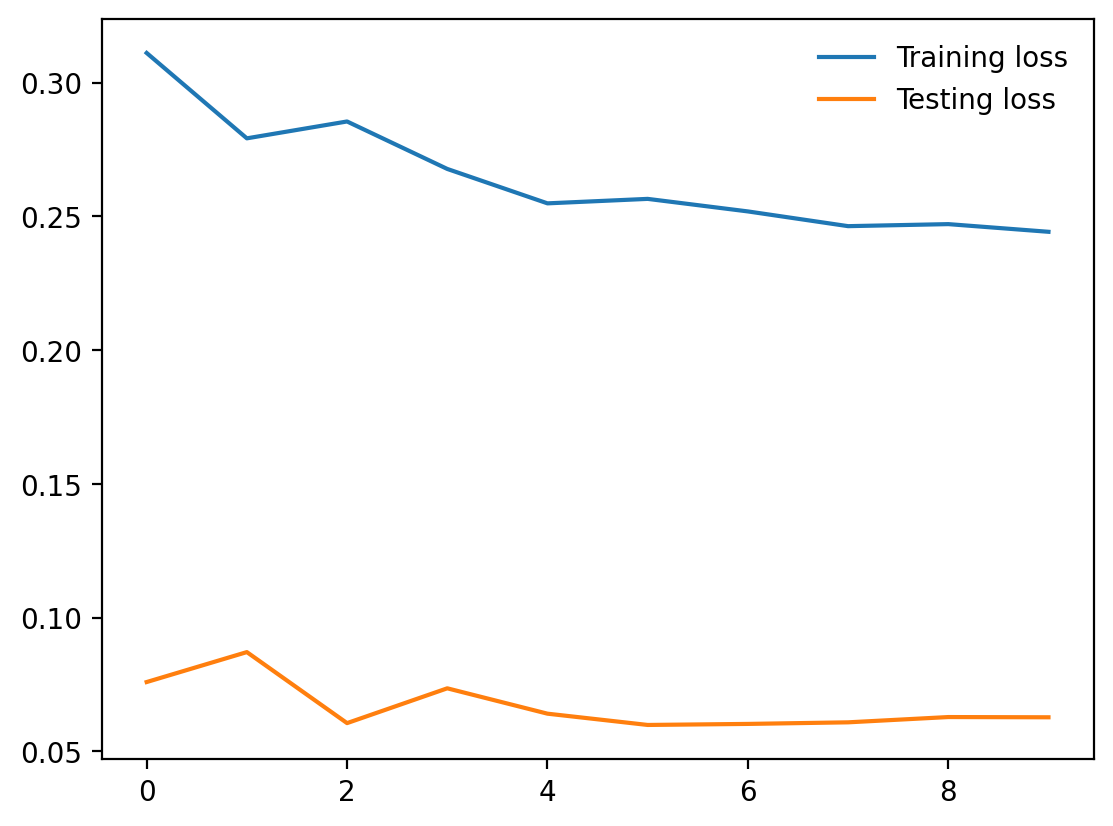

In [7]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Testing loss')
plt.legend(frameon=False)
plt.show()
